# Dice Reader

This project is meant to showcase how to use Tensorflow for a computer vision use case.  
The central themes showcased are the Convolutional Neural Network and the ImageDataGenerator.  

- ImageDataGenerator
    - load images and pass them to several other functions
    - "augment" the data creating rotated versions of the seed images
- Convolutional Neural Networks
    - architecture and implementation
    - training and tuning
    - evaluating performance

## Setup

This project assumes you have properly installed python and tensorflow (along with other useful packages).  
The code below simply import the proper libraries and set some global options.  

In [1]:
import zipfile
import glob
import re
from PIL import Image
from skimage import io
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
#options
np.set_printoptions(linewidth = 320)

2022-08-12 16:01:34.436624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 16:01:34.570041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-12 16:01:34.570061: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-08-12 16:01:35.080143: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-08-12 16:01:35.080204: W tensorflow/str

In [2]:
#utils
#plot images
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

## Early Stopping - Callback

One smart way to prevent overfitting when using neural network is to rely on "early stopping".
This simply means that training is interrupted earlier than planned. Generally, "earlier" means when the neural network reached a specific performance threshold in out-of-sample performance.

In [3]:
#callback (used to stop training if performance threshold is reached)
class endTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get("val_accuracy") > 0.95):
            print("\naccuracy above threshold")
            self.model.stop_training = True
#instantiate callback class
cb = endTrainingCallback()

## Seed images

To produce the taining (and validation, and testing) data, I decided to use data augmentation starting from six "seed images".  
Instead of having many example of dice, I used six pictures of the six faces of a die. The six seed images are then rotated by a random angle and manipulated in several ways before being stored in their final folders (used as sources for the ImageDataGenerator).  
  
Below, you can see the six seed images.

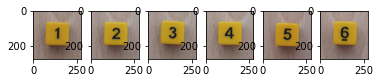

In [4]:
#load seed image
#one
im1 = io.imread("seedImages/seed_1/one.png")
im1 = im1.reshape((1, ) + im1.shape)
#two
im2 = io.imread("seedImages/seed_2/two.png")
im2 = im2.reshape((1, ) + im2.shape)
#three
im3 = io.imread("seedImages/seed_3/three.png")
im3 = im3.reshape((1, ) + im3.shape)
#four
im4 = io.imread("seedImages/seed_4/four.png")
im4 = im4.reshape((1, ) + im4.shape)
#five
im5 = io.imread("seedImages/seed_5/five.png")
im5 = im5.reshape((1, ) + im5.shape)
#six
im6 = io.imread("seedImages/seed_6/six.png")
im6 = im6.reshape((1, ) + im6.shape)
#merge into list
seedsImg = [im1, im2, im3, im4, im5, im6]

#plot seeds
plt.figure()
for indx in range(0, 6):
    plt.subplot(1, 6, indx + 1)
    plt.imshow(seedsImg[indx][0])


## Augmented data - create train, test, and validation exemplars

Below, I create the datasets by manipulating the seed images.
This process could be replicated "on the fly" instead of storing the final images. However, I wanted to see some example to evaluate their quality.  
When training the model, I'll use the ImageDataGeneraton "on the fly" drawing images from the train, test, and validation folders. This means that technically, the model is not trained on the images stored in those folders but on images created on demand based on the examples in the folders.  

In [5]:
howManyAug = 1000 #how many augmented examples
dirIndx = ["one", "two", "three", "four", "five", "six"] #list of seed classes
dirType = ["augmentedTrain/", "augmentedTest/", "augmentedValid/"]
#create ImageDataGenerator instance for loading and scaling seeds
loadAndPrepro = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = .2,
    height_shift_range = .2,
    rotation_range = 180,
    rescale = 1. / 255,
    zoom_range = .15,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = "nearest")

In [ ]:
#for each directory type
for typeIndx in dirType:
    #for each seed
    for indx in range(0, 6):
        #instantiate ImageDataGenerator (augmented)
        im_aug_iter = loadAndPrepro.flow(seedsImg[indx],
                                         batch_size = 16,
                                         save_to_dir = typeIndx + dirIndx[indx],
                                         save_prefix = "aug",
                                         save_format = "png")
        j = 0 #init counter
        for nextStep in im_aug_iter:
            j = j + 1
            if j >= howManyAug:
                break #exit


## ImageDataGenerator

Below, I created three generators drawing from the train, text, and validation folders.  
The source directory is the only difference among the generators.  

In [6]:
#target direcotires
train_dir = "augmentedTrain/"
test_dir = "augmentedTest/"
valid_dir = "augmentedValid/"
#create iterators
trainLoad = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = .2,
    height_shift_range = .2,
    rotation_range = 180,
    rescale = 1. / 255,
    zoom_range = .15,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = "nearest").flow_from_directory(
    train_dir,
    target_size = (275, 275),
    classes = ["one", "two", "three", "four", "five", "six"],
    batch_size = 32,
    class_mode = "categorical")
testLoad = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = .2,
    height_shift_range = .2,
    rotation_range = 180,
    rescale = 1. / 255,
    zoom_range = .15,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = "nearest").flow_from_directory(
    test_dir,
    target_size = (275, 275),
    classes = ["one", "two", "three", "four", "five", "six"],
    batch_size = 32,
    class_mode = "categorical")
validLoad = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range = .2,
    height_shift_range = .2,
    rotation_range = 180,
    rescale = 1. / 255,
    zoom_range = .15,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = "nearest").flow_from_directory(
    valid_dir,
    target_size = (275, 275),
    classes = ["one", "two", "three", "four", "five", "six"],
    batch_size = 32,
    class_mode = "categorical")

Found 5722 images belonging to 6 classes.
Found 5688 images belonging to 6 classes.
Found 5745 images belonging to 6 classes.


Below, you can find some examples from the training generator.  
Each picture is plotted and the target categories are provided in the form of category probability. 

In [7]:
imgs, labels = next(trainLoad)

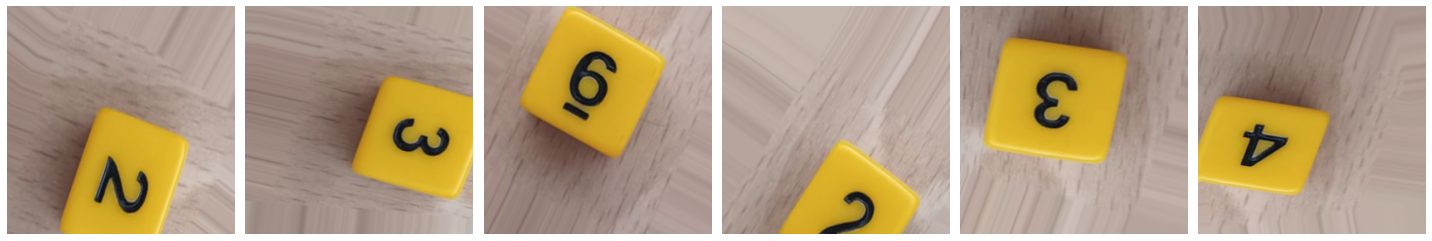

[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [8]:
plotImages(imgs[0:6])
print(labels[0:6])

## Define neural network architecture

The code below defines the convolutional neural network architecture and compiles the model.  
The neural network has  
- one sequential input layer
- two convolution/pooling segments (4 layers in total)  
- three densely connected layers wit relu activation  
- one output layer with 6 nodes (one per target category) with softmax activation (which normalizes the probabilities to sum to 1).

In [9]:
#neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape = (275, 275, 3),
                           filters = 64, kernel_size = (3, 3),
                           activation = "relu", padding = "same"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size =(3, 3),
                           activation = "relu", padding = "same"),
    tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 128, activation = tf.nn.relu),
    tf.keras.layers.Dense(units = 6, activation = "softmax")
])

2022-08-12 16:01:59.476298: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-12 16:01:59.476325: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-12 16:01:59.476342: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mbiellinux): /proc/driver/nvidia/version does not exist
2022-08-12 16:01:59.476518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The final arcitecture is displayied (and can be checked).

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 275, 275, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 137, 137, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 137, 137, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 68, 68, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 591872)            0         
                                                                 
 dense (Dense)               (None, 128)               7

The model is then compiled.  
The target metrics is accuracy, the loss function is categorical cross-entropy, and a learning rate of 0.0001 is hardwired into the model.

In [11]:
#compile network
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

## Training

The model is iteratively trained (see epochs parameter) using the training generator and training is interrupted using the callback (see above).  
In sample performance is computed on the training set while out of sample performance is computed on the validation set.  
Test set is reserved for model evaluation.  

In [12]:
#fit model
train_history = model.fit(
    x = trainLoad,
    steps_per_epoch = 8,
    epochs = 516,
    validation_data = validLoad,
    validation_steps = 8,
    verbose = 2,
    callbacks = cb)

Epoch 1/516
8/8 - 27s - loss: 1.8811 - accuracy: 0.1523 - val_loss: 1.8449 - val_accuracy: 0.1680 - 27s/epoch - 3s/step
Epoch 2/516
8/8 - 26s - loss: 1.8526 - accuracy: 0.1641 - val_loss: 1.7957 - val_accuracy: 0.1953 - 26s/epoch - 3s/step
Epoch 3/516
8/8 - 32s - loss: 1.8334 - accuracy: 0.1406 - val_loss: 1.8319 - val_accuracy: 0.1328 - 32s/epoch - 4s/step
Epoch 4/516
8/8 - 24s - loss: 1.8012 - accuracy: 0.1953 - val_loss: 1.7843 - val_accuracy: 0.2617 - 24s/epoch - 3s/step
Epoch 5/516
8/8 - 27s - loss: 1.7931 - accuracy: 0.1562 - val_loss: 1.7822 - val_accuracy: 0.1836 - 27s/epoch - 3s/step
Epoch 6/516
8/8 - 26s - loss: 1.7879 - accuracy: 0.1680 - val_loss: 1.7877 - val_accuracy: 0.2188 - 26s/epoch - 3s/step
Epoch 7/516
8/8 - 26s - loss: 1.7813 - accuracy: 0.1758 - val_loss: 1.7746 - val_accuracy: 0.1250 - 26s/epoch - 3s/step
Epoch 8/516
8/8 - 26s - loss: 1.7764 - accuracy: 0.2070 - val_loss: 1.7652 - val_accuracy: 0.2109 - 26s/epoch - 3s/step
Epoch 9/516
8/8 - 26s - loss: 1.7638 - a

### Storing the model

The model is stored on disk and retrieved again (retrieving is unnecessary as the model is currently in the environment).

In [13]:
#save trained model
model.save("trainedModel/diceRecognizer")

INFO:tensorflow:Assets written to: trainedModel/diceRecognizer/assets


INFO:tensorflow:Assets written to: trainedModel/diceRecognizer/assets


In [ ]:
#load saved model
model = tf.keras.models.load_model("trainedModel/diceRecognizer")

## Evaluation

The model's performance is evaluated using the test generator.  

### Train/Test Performance During training  

The in-sample and out-of-sample accuracy during training can be plotted as they are stored in the train_history object.

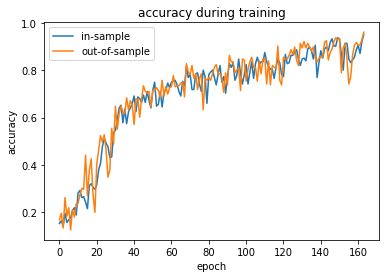

In [14]:
#accuracy, in-sample and out-of-sample
plt.plot(train_history.history["accuracy"])
plt.plot(train_history.history["val_accuracy"])
plt.title("accuracy during training")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["in-sample", "out-of-sample"], loc = "upper left")
plt.show()

### Performance gist

The model's performance is qualitatively investigated with six prediction instances.  

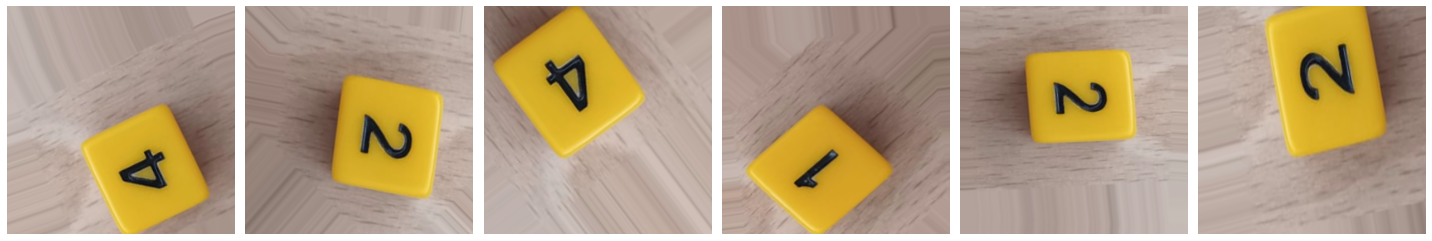

1/1 [==============================] - 0s 422ms/step


[2, 2, 4, 1, 2, 2]

In [15]:
test_imgs, test_labels = next(testLoad)
plotImages(test_imgs)
p = model.predict(test_imgs[0:6])
[np.argmax(i) + 1 for i in p]

### Performance exploration

The model's performance is probed by looking at the confusion matrix.

In [16]:
#extract batch
test_imgs, test_labels = next(testLoad)
#format labels
test_labels = [np.argmax(i) for i in test_labels]
#make predictions
p = model.predict(test_imgs)
#format predictions
p = [np.argmax(i) for i in p]
#condusion matrix
cfMat = tf.math.confusion_matrix(
    labels = test_labels,
    predictions = p,
)

1/1 [==============================] - 0s 447ms/step


In [17]:
#condusion matrix
cfMat

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[7, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0],
       [0, 1, 5, 0, 0, 0],
       [0, 0, 0, 5, 0, 0],
       [0, 0, 0, 0, 5, 0],
       [0, 0, 0, 0, 0, 7]], dtype=int32)>

### Performance assessment

The final model's performance is evaluated on a larger series of predictions.

In [18]:
#how many test batches?
testBatch = 100

#empty confusion matrix
cfMat_eval = np.zeros(shape = (6, 6))

#
for i in range(testBatch):
    #extract batch
    test_imgs, test_labels = next(testLoad)
    #format labels
    test_labels = [np.argmax(i) for i in test_labels]
    #make predictions
    p = model.predict(test_imgs)
    #format predictions
    p = [np.argmax(i) for i in p]
    #condusion matrix
    cfMat_new = tf.math.confusion_matrix(
        labels = test_labels,
        predictions = p,
    )
    #store confusion matrix
    cfMat_eval = cfMat_eval + cfMat_new


1/1 [==============================] - 0s 415ms/step


In [19]:
#display evaluation
print(cfMat_eval)

tf.Tensor(
[[518   0   0   0   0   0]
 [  0 422  81  16   0   0]
 [  0  53 482   0   0   0]
 [  0  15   3 539   0   0]
 [  0   0   0   0 521   0]
 [  0   0   0   1   1 548]], shape=(6, 6), dtype=int32)


In [20]:
#display evaluation
print("out-of-sample accuracy: " + str(np.sum(np.diagonal(cfMat_eval)) / np.sum(cfMat_eval)))

out-of-sample accuracy: 0.946875
